# Семантическая сегментация. Домашнее задание

В этом домашнем задании вам нужно будет реализовать и обучить модели сегментации родинок

## Датасет

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>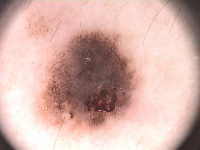</td><td>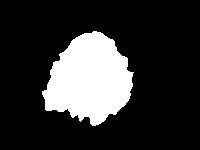</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2024-05-11 09:26:04--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2024-05-11 09:26:05--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf59ee994f6a992ea0ac7513346.dl.dropboxusercontent.com/cd/0/inline/CSoeSXcOdoiyjcWCLVTPl4v8ySbk6fl6CmbDF5WLG1Ov3iDPioDOLelScbdiXOVQPngH4ao-DWdW71YOO0uNWXWO9oD4YnevfRjrONcvipm7JzZXymBk227N8Q1eLWrf8Os/file# [following]
--2024-05-11 09:26:05--  https://ucf59ee994f6a992ea0ac7513346.dl.dropboxusercontent.com/cd/0/inline/CSoeSXcOdoiyjcWCLVTPl4v8ySbk6fl6CmbDF5WLG1Ov3iDPioDOLelScbdiXOVQPngH4ao-DWdW71YOO0uNWXWO9oD4YnevfRjrONcvipm7JzZXymB

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
!ls PH2Dataset/PH2\ Dataset\ images | wc -l

200


In [ ]:
images = glob("PH2Dataset/PH2 Dataset images/*")

### Задание 1

Изучите структуру данных и напишите класс датасета для загрузки изображений с их масками сегментации

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать cv2: [`cv2.imread()`](https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/)

In [ ]:
# TODO: импортитруйте библиотеки

class HumanDataset(Dataset):
    def __init__(self, images_paths, transform=None, target_transform=None):
        # TODO: задайте аргументы класса

    def __len__(self):
        # TODO: верните длину датасета

    def __getitem__(self, idx):
        # TODO:
        # 1. Считайте изображение соответствующее индексу
        # 2. Считайте маску сегментации для этого изображения
        # 3. Примените трансформ к изображению и маске
        # 4. Верните изображение и маску
        # Обратите внимание, что значения выходных массивов должны быть типа np.float32 от 0 до 1,
        # и размерность маски должна начинаться с кол-ва каналов - [1, 256, 256]
        if self.transform:
            ...
        return ...

### Задание 2

Разделите датасет на тренировочную, валидационную и тестовую выборки, создайте объекты класса Dataset.
Также выможете дописать свои аугментации в трансформы. Проверьте, что датасет выводит то что нужно с помощью визуализации. Затем создайте даталодеры для всех выборок.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ]
)

val_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

In [ ]:
import random

# TODO: создайте список путей для всех изображений и разделите его на выборки
# TODO: создайте объекты класса HumanDataset для каждой выборки
train_dataset = HumanDataset(...)
...

In [ ]:
# TODO: визуализируйте элементы датасета


In [ ]:
# TODO: создайте даталодеры для ваших выборок
# Hint: обратите внимание, что валидационную выборку не нужно перемешивать, а батчи должны быть одного размера (в том числе последний)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(...)
val_dataloader = DataLoader(...)

## Реализация архитектуры U-Net2

### Задание 3

1. Импортируйте необходимые библиотеки

In [ ]:
...

2. Реализуйте измененную архитектуру U-Net

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # TODO
        self.pool0 = ... # 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # TODO
        self.pool1 = ... # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # TODO
        self.pool2 = ...  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # TODO
        self.pool3 =  ...  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder (upsampling)
        # TODO
        self.upsample0 =  ... # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # TODO
        self.upsample1 = ... # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # TODO
        self.upsample2 = ... # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # TODO
        self.upsample3 = ... # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # concatenate over channels dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

## Лосс и метрики

### Задание 4

[**Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Или в упрощенной форме:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения минорного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + \sigma(\hat y_i)^\gamma(1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # TODO
    # Если у вас не получается верно реализовать даную формулу,
    # предлагаем поискать и адаптировать готовые реализации и возможные упрощения
    return ...

### Задание 5

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    # TODO
    return ...

Метрика с семинара

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Ноль если if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Ноль если оба равны 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # Избегаем 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # Сравнение с трэшхолдом

    return thresholded

## Функции для обучения

In [ ]:
# визуализация графиков обучения
def visualize(train_loss, val_loss, train_score, val_score, title):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_score, label = 'train_score')
    plt.plot(val_score, label = 'val_score')
    plt.title('Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')

    plt.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

In [ ]:
#!export LRU_CACHE_CAPACITY=1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from IPython.display import clear_output

# цикл обучения
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler, path):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    train_loss = []
    val_loss = []
    train_score = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_train_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # перенос на device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # обнуляем градиент в оптимизаторе
            opt.zero_grad()
            # forward
            with torch.set_grad_enabled(True):
                Y_pred = model(X_batch)

                avg_train_score += iou_pytorch(Y_pred>0, Y_batch).mean().item()

                loss =  loss_fn(Y_batch, Y_pred)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # обновление весов

                scheduler.step() # лучше выключить при обучении своей сети без претрейна
            # суммируем лосс чтобы вывести график
            avg_loss += loss / len(data_tr)

        avg_train_score = avg_train_score / len(data_tr)

        train_score.append(avg_train_score)
        train_loss.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        avg_val_loss = 0
        avg_val_score = 0
        # промежуточные результаты
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                # перенос на device
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                # forward
                Y_val_pred = model(X_val_batch)
                vall_loss =  loss_fn(Y_val_batch, Y_val_pred)# forward-pass
                avg_val_score += iou_pytorch(Y_val_pred >0, Y_val_batch).mean().item()
                # суммируем лосс
                avg_val_loss += vall_loss / len(data_val)

        val_loss.append(avg_val_loss)
        avg_val_score = avg_val_score / len(data_val)
        val_score.append(avg_val_score)

        Y_hat = model(X_val).detach().cpu() # перенос на cpu

        # Визуализация
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.save(model, path)
    return train_loss, val_loss, train_score, val_score

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    #model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def model_scorerer(model_class, path, max_epochs, loss, data_tr, data_val):
    model_name = str(model_class).split()[0][:-1]
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model_class.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

## Обучение

### Задание 6

Обучите модель U-Net2 с focal-loss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_loss_unet_focal, val_loss_unet_focal, train_score_unet_focal, val_score_unet_focal, model_unet_focal = \
model_scorerer(UNet2(), "unet_focal.pt", 20, focal_loss, train_dataloader, val_dataloader)

In [ ]:
train_loss_unet_focal = [x.cpu().detach().numpy() for x in train_loss_unet_focal]
val_loss_unet_focal = [x.cpu().detach().numpy() for x in val_loss_unet_focal]

visualize(train_loss_unet_focal, val_loss_unet_focal,
          train_score_unet_focal, val_score_unet_focal, "UNet + focal")

### Задание 7

Обучите модель U-Net2 с dice-locc

**Выводы:**

## Обучение с помощью mmsegmentation

### Задание 8

Установите необходимые зависимости и импортируйте библиотеки

In [ ]:
# TODO

### Задание 9

Напишите класс модели, которая будет состоять из бэкбона MobileNetV3 и головы FCNHead

In [ ]:
# TODO: импортируйте нужные модули из mmseg

In [ ]:
import torch
import torch.nn as nn

class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.backbone = # TODO
        self.head = # TODO

    def forward(self, x):
        # TODO
        # не забудьте увеличить размер выходной маски до размера входного изображения
        return ...

Загрузите предобученные веса для бэкбона

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/mobilenet_v3/lraspp_m-v3s-d8_512x1024_320k_cityscapes/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth

--2024-05-11 09:07:50--  https://download.openmmlab.com/mmsegmentation/v0.5/mobilenet_v3/lraspp_m-v3s-d8_512x1024_320k_cityscapes/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.20.179, 47.246.20.180, 47.246.20.181, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.20.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4666964 (4.5M) [application/octet-stream]
Saving to: ‘lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth’

lraspp_m-v3s-d8_512 100%[===================>]   4.45M  4.44MB/s    in 1.0s    

2024-05-11 09:07:52 (4.44 MB/s) - ‘lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth’ saved [4666964/4666964]



In [ ]:
tiny_model = TinyModel()

/usr/local/lib/python3.10/dist-packages/mmcv/cnn/bricks/hsigmoid.py:35: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmseg/models/decode_heads/decode_head.py:136: UserWarning: threshold is not defined for binary, and defaultsto 0.3
  warnings.warn('threshold is not defined for binary, and defaults'
/usr/local/lib/python3.10/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.10/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore

In [ ]:
model_name = '/content/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth'
w = torch.load(model_name, map_location='cpu');
w_backbone = {k.replace('backbone.', ''):v for k,v in w['state_dict'].items() if k.startswith('backbone.')}
tiny_model.backbone.load_state_dict(w_backbone)

<All keys matched successfully>

Проверьте вывод полученной модели

In [ ]:
# TODO

### Задание 10


Обучите модель с помощью тех же функций для обучения

In [ ]:
def model_scorerer(model, model_name, path, max_epochs, loss, data_tr, data_val):
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

In [ ]:
train_loss, val_loss, train_score, val_score, model = \
model_scorerer(tiny_model, "MobileNet+FCNHead", "MobileNet+FCNHead.pt", 20, focal_loss, train_dataloader, val_dataloader)

In [ ]:
train_loss = [x.cpu().detach().numpy() for x in train_loss]
val_loss = [x.cpu().detach().numpy() for x in val_loss]

visualize(train_loss, val_loss,
          train_score, val_score, "MobileNetV3 + FCNHead + focal")

## Выводы

### Задание 11

Сравните ваши эксперименты, сделайте выводы. Ответьте на следующие вопросы:
1. Не переобучаются ли ваши нейронные сети?
2. Достигаются ли максимально возможные метрики в каждом из экспериментов?
3. Как повлияла функция лосса на результаты, скорость и качество обучения?
4. Какой эксперимент дает наилучшие резултаты?